# Main Jupyter notebook for Urdf2Moon

Jupyter used for debugging. We try to add a term to the cost function which is dependent by the final state and the final control value

In [4]:
from __future__ import print_function, division, absolute_import, unicode_literals
import casadi as cs
from urdf2casadi import urdfparser as u2c
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import xml.etree.ElementTree as ET
import faulthandler
faulthandler.enable()

In [8]:
class Urdf2Moon:
    def __init__(self, urdf_path, root, tip, motor_inertias=None, sea_damping=None):
        """ Constructor method.
        Takes the bare minimum as inputs and it calculates basic function we'll be needing"""
        self.robot_parser = self.load_urdf(urdf_path)

        # Store inputs
        self.root = root
        self.tip = tip
        
        # Get basic info
        self.num_joints = self.get_joints_n()
        self.define_symbolic_vars()
        self.M, self.Cq, self.G = self.get_motion_equation_matrix()
        self.ee_pos = self.get_forward_kinematics()
        self.M_inv = cs.pinv(self.M)
        self.upper_q, self.lower_q, self.max_effort, self.max_velocity = self.get_limits()
        
        # Fix boundaries if not given
        self.upper_u, self.lower_u = self.format_properly(self.max_effort)
        self.upper_qd, self.lower_qd = self.format_properly(self.max_velocity)
        
        # SEA Stuff
        self.sea = any(self.get_joints_stiffness(urdf_path)) # True if at least one joint is sea
        if self.sea:
            self.K = self.get_joints_stiffness(urdf_path)
            self.SEAvars()
            self.B = self.get_B(motor_inertias)
            self.FDsea = self.get_FDsea(sea_damping)
            self.areMotor = self.B.any() # True when we're modeling also motor inertia


    def solve(self, cost_func, control_steps, initial_cond, trajectory_target, time_horizon=cs.MX.sym("T", 1), 
              final_term_cost=None, my_constraint=None, my_final_constraint=None,
              rk_interval=4, max_iter=250):
        """ Solve method. Takes the problems conditions as input and returns its solution"""
        
        # Store Values
        self.t = cs.SX.sym("t", 1)
        self.traj ,self.traj_dot = self.derive_trajectory(trajectory_target, self.t)
        self.cost_func = cost_func
        self.final_term_cost = final_term_cost
        self.my_constraint = my_constraint
        self.my_final_constraint = my_final_constraint
        self.T = time_horizon
        self.N = control_steps
        self.rk_intervals = rk_interval
        self.max_iter = max_iter
        if len(initial_cond) == 2*self.num_joints:
            self.initial_cond = initial_cond
        else:
            raise ValueError('List should be {} item long: (q, q_dot)'.format(2*self.num_joints))
        

        # Working it up
        self.f = self.get_diff_eq(self.cost_func, self.traj)
        self.F = self.rk4(self.f, self.T, self.N, self.rk_intervals)
        self.nlp_solver(self.initial_cond, self.final_term_cost, trajectory_target, self.my_constraint)
        return {'q': self.q_opt, 'qd': self.qd_opt, 
                'u': self.u_opt}

    def load_urdf(self, urdf_path):
        robot_parser = u2c.URDFparser()
        robot_parser.from_file(urdf_path)
        return robot_parser
    def get_joints_n(self):
        return self.robot_parser.get_n_joints(self.root, self.tip) #return the number of actuated joints
    def define_symbolic_vars(self):
        self.q = cs.SX.sym("q", self.num_joints)
        self.q_dot = cs.SX.sym("q_dot", self.num_joints)
        self.u = cs.SX.sym("u", self.num_joints) 
        self.ee = cs.SX.sym("ee", 1)
    def get_motion_equation_matrix(self):
        # load inertia terms (function)
        self.M_sym = self.robot_parser.get_inertia_matrix_crba(self.root, self.tip)
        # load gravity terms (function)
        gravity_u2c = [0, 0, -9.81]
        self.G_sym = self.robot_parser.get_gravity_rnea(self.root, self.tip, gravity_u2c)
        # load Coriolis terms (function)
        self.C_sym = self.robot_parser.get_coriolis_rnea(self.root, self.tip)
        # load frictional matrices
        self.Ff, self.Fd = self.robot_parser.get_friction_matrices(self.root, self.tip)
        return self.M_sym(self.q), self.C_sym(self.q, self.q_dot), self.G_sym(self.q)
    def get_forward_kinematics(self):
        fk_dict = self.robot_parser.get_forward_kinematics(self.root, self.tip)
        dummy_sym = cs.MX.sym('dummy', self.num_joints)
        FK_sym = fk_dict["T_fk"] # ee position
        ee = FK_sym(dummy_sym)[0:3,3]
        ee_pos = cs.Function('ee_pos', [dummy_sym], [ee])
        return ee_pos
    def get_limits(self):
        _, self.actuated_list, upper_q, lower_q = self.robot_parser.get_joint_info(self.root, self.tip)
        max_effort, max_velocity = self.robot_parser.get_other_limits(self.root, self.tip)
        return upper_q, lower_q, max_effort, max_velocity
    # SEA Methods
    def SEAvars(self):
        self.theta = cs.SX.sym("theta", self.num_joints)
        self.theta_dot = cs.SX.sym("theta_dot", self.num_joints)
        self.tau_sea = self.K@(self.q - self.theta)
    def get_joints_stiffness(self, urdf_path):
        tree = ET.parse(urdf_path)
        results = {}
        for gazebo in tree.findall('gazebo/plugin'):
            try:
                results[gazebo.find('joint').text] = float(gazebo.find('stiffness').text)
            except:
                pass
        in_list = [results.get(joint, 0) for joint in self.actuated_list]
        return np.diag(in_list)
    def get_B(self, motor_inertias):
        if motor_inertias is None: motor_inertias = {}
        in_list = [motor_inertias.get(joint, 0) for joint in self.actuated_list]
        return np.diag(in_list)
    def get_FDsea(self, sea_damping):
        if sea_damping is None: sea_damping = {}
        in_list = [sea_damping.get(joint, 0) for joint in self.actuated_list]
        return np.diag(in_list)

    def format_properly(self, item):
        if item == None:
            upper = [float('inf')] * self.num_joints
            lower = [-float('inf')] * self.num_joints
        elif isinstance(item, list):
            if len(item) == self.num_joints:
                upper = item
                lower = [-x for x in item]
            else:
                raise ValueError('List lenght does not match the number of joints! It should be long {}'.format(self.num_joints))
        elif isinstance(item, (int, float)):
            upper = [item] * self.num_joints
            lower = [-item] * self.num_joints
        else:
            raise ValueError('Input should be a number or a list of numbers')
        return upper, lower

    def get_diff_eq(self, cost_func, traj):
        # Right Hand side of differential equations!
        RHS = []
        rhs1 = self.q_dot
        rhs2 = self.M_inv@(-self.Cq -self.G -self.Fd@self.q_dot -self.Ff@cs.sign(self.q_dot))
        
        if self.sea and self.areMotor: # Modeling both SEA and motor inertia
            # Right Hand Side of differential equations
            rhs2 += -self.M_inv@self.tau_sea
            rhs3 = self.theta_dot
            rhs4 = cs.pinv(self.B)@(-self.FDsea@self.q_dot +self.u +self.tau_sea)
            RHS = [rhs1, rhs2, rhs3, rhs4]
            # State  variable
            self.x = cs.vertcat(self.q, self.q_dot, self.theta, self.theta_dot)
            self.num_state_var = self.num_joints*2
            self.lower_q = self.lower_q*2
            self.lower_qd = self.lower_qd*2
            self.upper_q = self.upper_q*2
            self.upper_qd = self.upper_qd*2
            
        elif self.sea and not self.areMotor: # Modeling only SEA --- TODO
            rhs2 += -self.M_inv@self.tau_sea + self.M_inv@self.u
            rhs3 = self.theta_dot
            rhs4 = -self.K@(self.theta-self.q)
            RHS = [rhs1, rhs2, rhs3, rhs4]
            # State  variable
            self.x = cs.vertcat(self.q, self.q_dot, self.theta, self.theta_dot)
            
        else:   # No SEA nor motor inertias
            rhs2 += self.M_inv@self.u
            RHS = [rhs1, rhs2]
            # State  variable
            self.x = cs.vertcat(self.q, self.q_dot)
            self.num_state_var = self.num_joints
        
        J_dot = cost_func(self.q-self.traj, self.q_dot-self.traj_dot, self.u)
        
        self.x_dot = cs.vertcat(*RHS)
        f = cs.Function('f', [self.x, self.u, self.t],    # inputs
                             [self.x_dot, J_dot])  # outputs
        return f
    def rk4(self, f, T, N, m):
        Trk4 = cs.MX.sym('Trk4', 1)
        dt = T/N/m

        # variable definition for RK method
        X0 = cs.MX.sym('X0', self.num_state_var * 2)
        U = cs.MX.sym('U', self.num_joints)
        t = cs.MX.sym('t', 1)

        # Initial value
        X = X0
        Q = 0

        # Integration
        for j in range(m):
            k1, k1_q = f(X,  U,  t)
            k2, k2_q = f(X + dt/2 @ k1, U,  t)
            k3, k3_q = f(X + dt/2 @ k2, U,  t)
            k4, k4_q = f(X + dt @ k3, U,  t)
            # update the state
            X = X + dt/6@(k1 +2*k2 +2*k3 +k4)    
            # update the cost function 
            Q = Q + dt/6@(k1_q + 2*k2_q + 2*k3_q + k4_q)

        F = cs.Function('F', [X0, U, t], [X, Q],['x0','p','time'],['xf','qf'])
        return F
    def nlp_solver(self, initial_cond, final_term_cost, trajectory_target, my_constraints):
        # Start with an empty NLP
        w       = []    #input vector
        w_g     = []    #initial guess
        lbw     = []    #lower bounds of inputs
        ubw     = []    #upper bounds of inputs 
        J       = 0     #initial value of cost func
        g       = []    #joint state for all timesteps
        lbg     = []    #lower bounds of states
        ubg     = []    #upper bound of states
        
        self.t = cs.MX.sym("t", 1)
        self.traj ,self.traj_dot = self.derive_trajectory(trajectory_target, self.t)
        Xk = cs.MX.sym('X0', self.num_state_var*2) # MUST be coherent with the condition specified abow
        w += [Xk]
        if self.sea:
            initial_cond = initial_cond * 2
        w_g  += initial_cond
        lbw += initial_cond
        ubw += initial_cond
        # Integration!
        dt = self.T/self.N
        for k in range(self.N):
            # New NLP variable for the control
            Uk = cs.MX.sym('U_' + str(k), self.num_joints) # generate the k-th control command, 2x1 dimension
            w += [Uk]       # list of commands [U_0, U_1, ..., U_(N-1)]
            w_g += [0] * self.num_joints  # initial guess
            
            # Add inequality constraint on inputs
            lbw += self.lower_u       # lower bound on u
            ubw += self.upper_u       # upper bound on u
            
            # Integrate till the end of the interval
            Fk = self.F(x0=Xk, p=Uk, time=dt*k)     #That's the actual integration!
            Xk_end = Fk['xf']
            J  = J+Fk['qf']
    
            # New NLP variable for state at end of interval
            Xk = cs.MX.sym('X_' + str(k+1), 2*self.num_state_var)
            w  += [Xk]
            w_g += [0] * (2*self.num_state_var) # initial guess
            
            # Add inequality constraint on state
            lbw += self.lower_q      # lower bound on q
            lbw += self.lower_qd #lower bound on q_dot
            ubw += self.upper_q      # upper bound on q
            ubw += self.upper_qd # upper bound on q_dot

            # Add equality constraint
            g   += [Xk_end-Xk]
            lbg += [0] * (2*self.num_state_var)
            ubg += [0] * (2*self.num_state_var)
            
            # get forward kinematics
            EEk_pos = self.ee_pos(Xk[0:self.num_joints])
            # add custom constraints
            if my_constraints != None:
                self.add_constraints(g, lbg, ubg, Xk, Uk, EEk_pos, my_constraints)
    
        if isinstance(self.T, cs.casadi.MX):
            w += [self.T]
            w_g += [1.0]
            lbw += [0.05]
            ubw += [float('inf')]
    
        # add a final term cost. If not specified is 0.
        if final_term_cost != None:
            J = J+final_term_cost(Xk_end[0:self.num_joints]-cs.substitute(self.traj,self.t,self.T), Xk_end[self.num_joints:]-cs.substitute(self.traj_dot,self.t,self.T), Uk) # f_t_c(q, qd, u)    
            
        if self.my_final_constraint != None:
            self.add_constraints(g, lbg, ubg, Xk, Uk, EEk_pos, self.my_final_constraint)
            
        # Define the problem to be solved
        problem = {'f': J, 'x': cs.vertcat(*w), 'g': cs.vertcat(*g)}
        # NLP solver options
        opts = {}
        opts["ipopt"] = {'max_iter': self.max_iter}
        # Define the solver and add boundary conditions
        solver = cs.nlpsol('solver', 'ipopt', problem, opts)
        solver = solver(x0=w_g, lbx=lbw, ubx=ubw, lbg=lbg, ubg=ubg)

        # Solve the NLP
        opt = solver['x']
        if isinstance(self.T, cs.casadi.MX):
            self.T_opt = opt[-1]
            opt = opt[0:-1]
        else:
            self.T_opt = self.T
        
        if self.sea:
            self.q_opt = [opt[idx::(3*(self.num_joints)+ 2*(self.num_joints))]for idx in range(self.num_joints)]
            self.qd_opt = [opt[self.num_joints+idx::(3*(self.num_joints)+ 2*(self.num_joints))]for idx in range(self.num_joints)]
            self.theta_opt = [opt[self.num_joints*2+idx::(3*(self.num_joints)+ 2*(self.num_joints))]for idx in range(self.num_joints)]
            self.thetad_opt = [opt[self.num_joints*2+ self.num_joints+idx::(3*(self.num_joints)+ 2*(self.num_joints))]for idx in range(self.num_joints)]
            self.u_opt = [opt[self.num_joints*2+ 2*(self.num_joints)+idx::(3*(self.num_joints)+ 2*(self.num_joints))]for idx in range(self.num_joints)]
        else:
            self.q_opt = [opt[idx::3*self.num_joints]for idx in range(self.num_joints)]
            self.qd_opt = [opt[self.num_joints+idx::3*self.num_joints]for idx in range(self.num_joints)]
            self.u_opt = [opt[self.num_joints*2+idx::3*self.num_joints]for idx in range(self.num_joints)]
            

    def add_constraints(self, g_, lbg_, ubg_, Xk_, Uk_, EEk_pos_,  my_constraints_):
        for constraint in my_constraints_:
            l_bound, f_bound, u_bound = constraint(Xk_[0:self.num_joints], Xk_[self.num_joints:], Uk_, EEk_pos_)
            if not isinstance(f_bound, list): f_bound = [f_bound]
            if not isinstance(l_bound, list): l_bound = [l_bound]
            if not isinstance(u_bound, list): u_bound = [u_bound]
            g_   += f_bound
            lbg_ += l_bound
            ubg_ += u_bound
            
    def derive_trajectory(self, traj, t):
        if isinstance(traj(t)[0], list): # If user gave also traj_dot as input then
            traj_dot = cs.vertcat(*traj(t)[1])
            traj = cs.vertcat(*traj(t)[0])
        else:
            traj_dot = [cs.jacobian(traj(t)[idx],t) for idx in range(self.num_joints)] # If user did not give traj_dot, then derive it from traj
            traj = cs.vertcat(*traj(t))
            traj_dot = cs.vertcat(*traj_dot)
        return traj, traj_dot
    def print_results(self):
        tgrid = [self.T_opt/self.N*k for k in range(self.N+1)]

        fig, axes = plt.subplots(nrows=int(ceil(self.num_joints/2)), ncols=2, figsize=(15, 4*ceil(self.num_joints/2)))
        
        for idx, ax in enumerate(fig.axes):
            if idx < self.num_joints:
                self.get_ax(ax, idx, tgrid)

        return fig    
    def get_ax(self, ax, idx, tgrid):
        ax.plot(tgrid, self.q_opt[idx], '--')
        ax.plot(tgrid, self.qd_opt[idx], '--')
        ax.plot(tgrid[1:], self.u_opt[idx], '-.')
        legend = ['q'+str(idx),'q' + str(idx) +'_dot','u' + str(idx)]
        if self.sea:
            ax.plot(tgrid, self.theta_opt[idx], '.')
            ax.plot(tgrid, self.thetad_opt[idx], '.')
            legend += ['theta' + str(idx),  'theta' + str(idx) +'_dot']
        ax.legend(legend)
        return ax

This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      396
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:      295

Total number of variables............................:      150
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:      100
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

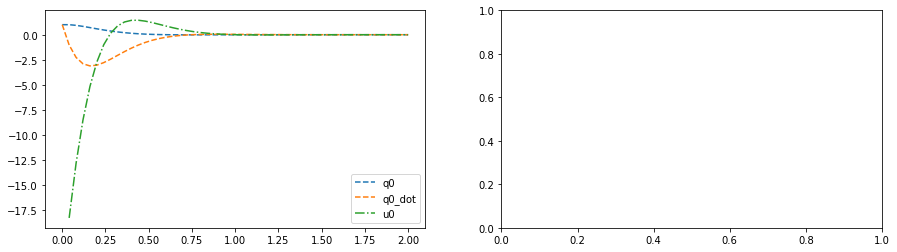

In [9]:
if __name__ == '__main__':
    if True:
        urdf_path = "../urdf/rrbot.urdf"
        root = "link1" 
        end = "link2"
        def trajectory_target(t):
            q = [0, 0]
            return q
        in_cond = [1]*2


    def my_cost_func(q, qd, u):
        return 10 * cs.mtimes(q.T,q) + cs.mtimes(u.T,u) / 10

    def my_final_term_cost(q_f, qd_f, u_f):
        return 100*cs.mtimes(q_f.T,q_f)  # + cs.mtimes(qd_f.T,qd_f)
    

    time_horizon = 1
    steps = 50
    B = {'J1' : 1}
    
    urdf_2_opt = Urdf2Moon(urdf_path, root, end)
    opt = urdf_2_opt.solve(my_cost_func, steps, in_cond, trajectory_target, time_horizon=2)
    fig = urdf_2_opt.print_results()